# Analyse, classification et indexation des données: feuille 6
### Classifieur bayésien

Dans la première partie de ce TD on s’appuie sur l’exemple du cours qui consiste à séparer des poissons en deux classes : bars et saumons. La classification sera faite à partir d’une seule caractéristique (la longueur) dans un premier temps, puis à partir de deux caractéristiques (longueur et brillance). En d’autres termes, le descripteur sera d’abord de dimension 1 puis de dimension 2.

#### Données
Dans cet exercice, nous allons travailler avec un fichier (<code>salmon_seabass.csv</code>) contenant des informations sur la longueur et la brillance de deux classes de poissons : les saumons et les bars.
Le fichier est disponible à l'adresse : 

https://www.labri.fr/perso/zemmari/datasets/salmon_seabass.csv

1- Chargez le fichier, et notez que la colonne <code>species</code> indique la catégorie du poisson : 

    - 0 : il s'agit d'un saumon 
    - 1 : il s'agit d'un bar


In [73]:
import pandas as pa

In [74]:
seabass = pa.read_csv('https://www.labri.fr/perso/zemmari/datasets/salmon_seabass.csv', delimiter=';', header=0)

In [75]:
print(seabass.head())
print(seabass.info())

   lightness     width  species
0   9.710457  8.673699        0
1   6.528089  7.330887        0
2   1.770695  7.599677        0
3   4.819293  7.328198        0
4   6.769638  8.575629        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lightness  1500 non-null   float64
 1   width      1500 non-null   float64
 2   species    1500 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 35.3 KB
None


2- Affichez le nombre de valeurs fournies pour chacune des deux classes. On les nommera <code>sizeVTSaumon</code>
et <code>sizeVTBar</code>. 

In [76]:
sizeVTSaumon = (seabass['species'] == 0).sum()
sizeVTBar = (seabass['species'] == 1).sum()

print("size of saumon :", sizeVTSaumon)
print("size of bar :", sizeVTBar)

size of saumon : 1000
size of bar : 500


### Exercice 1. classifieur avec une seule dimension

### 1.0 Préalable
Dans un premier temps, nous allons considérer un seul descripteur : la longueur <code>width</code> des poissons. 

a- Mélanger les données.

In [77]:

seabass_shuffled = seabass.sample(frac=1, random_state=1500)
print(seabass_shuffled)

      lightness      width  species
1338   7.297558  13.309070        1
1038  10.462884  18.932520        1
462    6.690536   7.556233        0
624    7.665178  10.412443        0
538    4.245410   9.146918        0
...         ...        ...      ...
450    5.483418   7.396482        0
878    1.927274   6.155747        0
893    4.723484   8.540314        0
193    7.299750   6.503081        0
1299  14.611562  10.255437        1

[1500 rows x 3 columns]


b- Créer deux variables $X$ et $y$ respectivement la longueur du poisson et son espèce

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline
X = seabass_shuffled['width']
y = seabass_shuffled['species']


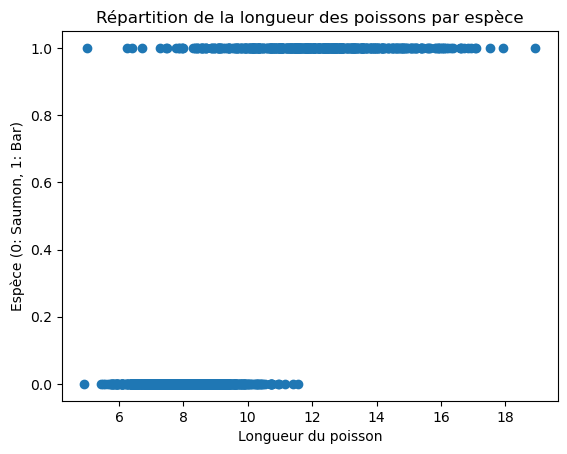

In [79]:
plt.scatter(X, y)
plt.xlabel("Longueur du poisson")
plt.ylabel("Espèce (0: Saumon, 1: Bar)")
plt.title("Répartition de la longueur des poissons par espèce")
plt.show()

c-  Découper les données en deux parties : 80% pour l'entrainement et 20% pour le test.

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

#### 1.1. Classifieur ML

a- Calculer les estimateurs non biaisés de la moyenne et de l'écart type pour chacune des espèces de poisson. Attention, il faut travailler sur la portion d'entraînement du dataset.  


In [82]:
import numpy as np

In [83]:
train_saumon = X_train[Y_train == 0]
train_bar = X_train[Y_train == 1]

mean_saumon = train_saumon.mean()
std_saumon = train_saumon.std()
mean_bar = train_bar.mean()
std_bar = train_bar.std()

print("Moyenne de la longueur pour les saumons :", mean_saumon)
print("Écart type de la longueur pour les saumons :", std_saumon)

print("Moyenne de la longueur pour les bars :", mean_bar)
print("Écart type de la longueur pour les bars :", std_bar)


Moyenne de la longueur pour les saumons : 8.041005907983783
Écart type de la longueur pour les saumons : 1.001435816670688
Moyenne de la longueur pour les bars : 12.063848077692121
Écart type de la longueur pour les bars : 2.0536139591054106


b- Dessiner les courbes des lois normales correspondant à la fonction de maximum de vraisemblance. Indiquer la frontière de décision. Quelle est l'espèce prédite d'un poisson de longueur 12 ?

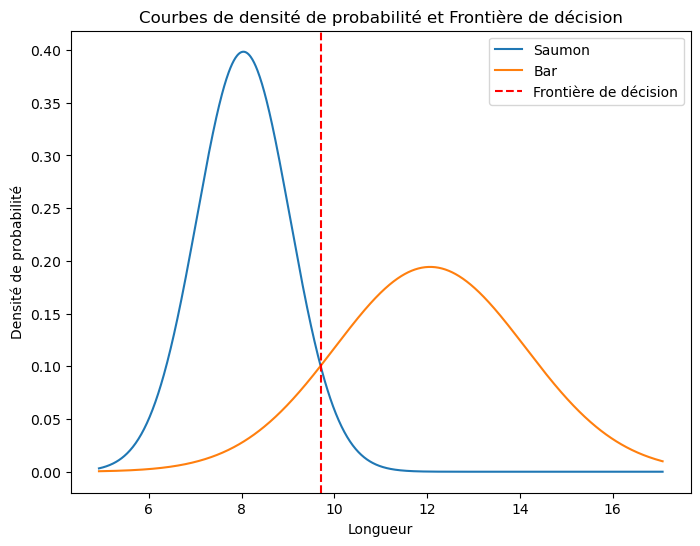

In [84]:
from scipy.stats import norm

x = np.linspace(min(X_train), max(X_train), 1000)  # Plage de valeurs possibles de la longueur
pdf_saumon = norm.pdf(x, loc=mean_saumon, scale=std_saumon)
pdf_bar = norm.pdf(x, loc=mean_bar, scale=std_bar)

plt.figure(figsize=(8, 6))
plt.plot(x, pdf_saumon, label='Saumon')
plt.plot(x, pdf_bar, label='Bar')
plt.xlabel('Longueur')
plt.ylabel('Densité de probabilité')
plt.legend()


intersection = np.argmin(np.abs(pdf_saumon - pdf_bar))
decision_boundary = x[intersection]
plt.axvline(x=decision_boundary, color='r', linestyle='--', label='Frontière de décision')

plt.legend()
plt.title('Courbes de densité de probabilité et Frontière de décision')
plt.show()

L'espèce prédite d'un poisson de longueur 12 est un bar 



c- Evaluer la qualité du modèle entrainé.

In [85]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_predictions = []

for length in X_train:
    if mean_saumon < length < mean_bar:
        test_predictions.append(1)
    else:
        test_predictions.append(0)

In [86]:
confusion = confusion_matrix(Y_train, test_predictions)
print("Matrice de confusion :")
print(confusion)

accuracy = accuracy_score(Y_train, test_predictions)
print("Exactitude : {:.2f}".format(accuracy))


Matrice de confusion :
[[396 400]
 [207 197]]
Exactitude : 0.49


#### 1.2. Classifieur MAP

a- Ecrire une fonction <code>classify()</code> permettant également de classifier les poissons mais en utilisant cette fois un classifieur a posteriori.

In [103]:
prior_saumon=len(train_saumon)/len(X_train)
prior_bar=len(train_bar)/len(X_train)
    
def classify():
    predicted_classes = [] 
    for length in X_test:
        posterior_saumon = prior_saumon * norm.pdf(length, loc=mean_saumon, scale=std_saumon)
        posterior_bar = prior_bar * norm.pdf(length, loc=mean_bar, scale=std_bar)
        if posterior_saumon > posterior_bar:
            predicted_classes.append(0)
        else:
            predicted_classes.append(1)
    return predicted_classes


b- Evaluer ce classifieur 

In [104]:
predicted_classes = classify()

accuracy = accuracy_score(Y_test, predicted_classes)
print("Exactitude du classifieur MAP : {:.2f}".format(accuracy))


Exactitude du classifieur MAP : 0.93


### Exercice 2. Classifieur avec deux descripteurs 

Dans cet exercice, nous allons considérer le dataset dans sa globalité. Nous allons donc baser notre classification sur les deux descripteurs <code>width</code> et <code>lightness</code>.

Reprogrammer et tester les deux classifieurs vus dans l'exercice 1. Quel est l'impact du rajout du nouveau descripteur ?

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline
X = seabass_shuffled[['width', 'lightness']]
y = seabass_shuffled['species']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [118]:
train_saumon = X_train[Y_train == 0]
train_bar = X_train[Y_train == 1]

mean_saumon = np.mean(train_saumon, axis=0)
std_saumon = np.std(train_saumon, axis=0)
mean_bar = np.mean(train_bar, axis=0)
std_bar = np.std(train_bar, axis=0)


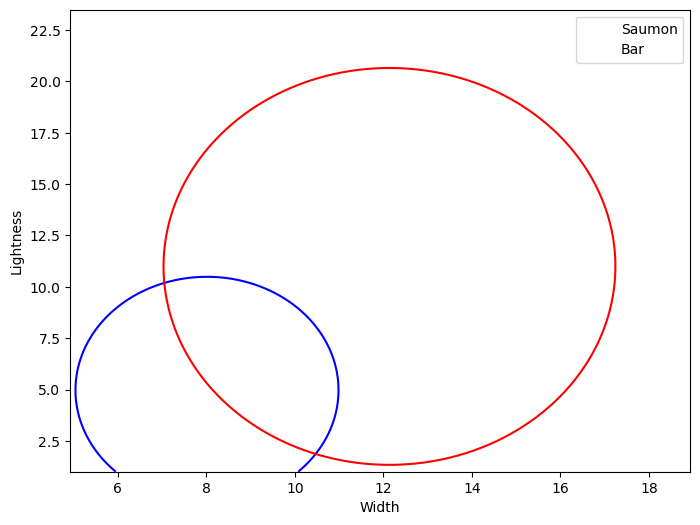

In [119]:
x_width = np.linspace(min(X_train['width']), max(X_train['width']), 1000)
x_lightness = np.linspace(min(X_train['lightness']), max(X_train['lightness']), 1000)

X_width, X_lightness = np.meshgrid(x_width, x_lightness)
pdf_saumon_width = norm.pdf(X_width, loc=mean_saumon[0], scale=std_saumon[0])
pdf_saumon_lightness = norm.pdf(X_lightness, loc=mean_saumon[1], scale=std_saumon[1])

pdf_bar_width = norm.pdf(X_width, loc=mean_bar[0], scale=std_bar[0])
pdf_bar_lightness = norm.pdf(X_lightness, loc=mean_bar[1], scale=std_bar[1])

plt.figure(figsize=(8, 6))
contour_saumon = plt.contour(X_width, X_lightness, pdf_saumon_width * pdf_saumon_lightness, levels=[0.001], colors='blue')
contour_bar = plt.contour(X_width, X_lightness, pdf_bar_width * pdf_bar_lightness, levels=[0.001], colors='red')

plt.xlabel('Width')
plt.ylabel('Lightness')

# Ajouter des légendes
contour_saumon.collections[0].set_label('Saumon')
contour_bar.collections[0].set_label('Bar')
plt.legend()

In [120]:
test_predictions = []

for i in range(len(X_test)):
    likelihood_saumon = norm.pdf(X_test.iloc[i], loc=mean_saumon, scale=std_saumon)
    likelihood_bar = norm.pdf(X_test.iloc[i], loc=mean_bar, scale=std_bar)
    posterior_saumon = likelihood_saumon[0] * likelihood_saumon[1]
    posterior_bar = likelihood_bar[0] * likelihood_bar[1]
    
    if posterior_saumon > posterior_bar:
        test_predictions.append(0)
    else:
        test_predictions.append(1)

In [121]:
confusion = confusion_matrix(Y_test, test_predictions)
print("Matrice de confusion :")
print(confusion)

accuracy = accuracy_score(Y_test, test_predictions)
print("Exactitude : {:.2f}".format(accuracy))

Matrice de confusion :
[[175   6]
 [  7 112]]
Exactitude : 0.96


In [122]:
# Classifieur MAP
prior_saumon = len(train_saumon) / len(X_train)
prior_bar = len(train_bar) / len(X_train)

def classify():
    predicted_classes = [] 
    for i in range(len(X_test)):
        likelihood_saumon = norm.pdf(X_test.iloc[i], loc=mean_saumon, scale=std_saumon)
        likelihood_bar = norm.pdf(X_test.iloc[i], loc=mean_bar, scale=std_bar)
        posterior_saumon = prior_saumon * likelihood_saumon[0] * likelihood_saumon[1]
        posterior_bar = prior_bar * likelihood_bar[0] * likelihood_bar[1]
        
        if posterior_saumon > posterior_bar:
            predicted_classes.append(0)
        else:
            predicted_classes.append(1)
    return predicted_classes

In [123]:

# Evaluer le classifieur MAP
predicted_classes = classify()

accuracy = accuracy_score(Y_test, predicted_classes)
print("Exactitude du classifieur MAP : {:.2f}".format(accuracy))

Exactitude du classifieur MAP : 0.96


### Exercice 3. Bayes avec <code>sklearn</code>

Comparer vos résultats avec ceux obtenus avec un classifieur de Bayes de la bibliothèque <code>sklearn</code>.

In [127]:
import matplotlib.pyplot as plt
%matplotlib inline
X = seabass_shuffled[['width', 'lightness']]
y = seabass_shuffled['species']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [128]:
from sklearn.naive_bayes import GaussianNB

In [129]:
naive_bayes_classifier = GaussianNB()

# Entraînez le modèle sur les données d'entraînement
naive_bayes_classifier.fit(X_train, Y_train)

# Faites des prédictions sur les données de test
predicted_classes_sklearn = naive_bayes_classifier.predict(X_test)

# Évaluez la qualité du modèle Bayesien de scikit-learn
accuracy_sklearn = accuracy_score(Y_test, predicted_classes_sklearn)
print("Exactitude du classifieur Bayesien de scikit-learn : {:.2f}".format(accuracy_sklearn))


Exactitude du classifieur Bayesien de scikit-learn : 0.97
